# Comparing the different Polymath projects

We start by setting up, loading the urls of the discussions, and putting everything in a frame.

In [1]:
import yaml
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20, 20)

from bs4 import BeautifulSoup
from collections import Counter
from itertools import chain, product
import json
import networkx as nx
import pandas as pd
from pandas import DataFrame
from urllib.parse import urlparse
import datetime

from comment_thread import *
from author_network import *

Is **Polymath7-1** really a research-thread? (this is the first post)
This question can be generalised to most other "first posts/threadds" !!

Keep in mind that cashing requests leads to missing new content (at least in PM10)!

In [2]:
IS_RESEARCH = {'pm 1': [False, True, True, True, True, True, True, True, True, True, True, True, False, True, True, False, True, False, False, False, False, False],
               'mini_pm 1': [True, True, False],
               'mini_pm 2': [False, False, False, False, True],
               'pm 6': [True, False],
               'mini_pm 3': [False, False, True],
               'mini_pm 4': [False, False, False, True, True]}

In [3]:
def process_polymath(project, split=False):
    message = "Polymath {}".format(project.split(" ")[-1]) if project.startswith("pm") else "Mini Polymath {}".format(project[-1])
    SETTINGS = {
    'msg' : message,
    'filename' : message.replace(" ", ""),
    'source' : project.replace(" ", ""),
    'urls' : [],
    'type' : '',
    'parser' : 'html5lib',
    'cmap' : plt.cm.Paired, # not a string, this is an object
    'vmin' : 1,
    'vmax' : 100}
    
    #with open("DATA/" + SETTINGS['source'] + ".csv", "r") as input:
    #    pm_frame = pd.read_csv(input, index_col="Ord")
    
    with open("DATA/"+ SETTINGS['source'] + ".txt", "r") as input:
        soup = BeautifulSoup(input.readline(), "html.parser")
    
    #items = soup.find("ul").find_all("li")
    urls, titles = zip(*[(item.get("href"), item.text) for item in soup.find_all("a")])
    
    research = IS_RESEARCH[project] if project in IS_RESEARCH else ["discussion" not in title.lower() for title in titles]
        
    pm_frame = DataFrame({
        'url': urls,
        'title' : titles,
        'blog' : [urlparse(url).netloc.split('.')[0].title() for url in urls],
        'research' : research},
        columns = ['title', 'url', 'blog', 'research'])
        
    pm_frame['thread'] = [THREAD_TYPES[blog](url) for (url, blog) in zip(pm_frame['url'], pm_frame['blog'])]
    pm_frame['number of comments'] = pm_frame['thread'].apply(lambda thread: len(thread.node_name.keys()))
    pm_frame['number of comments (accumulated)'] = pm_frame['number of comments'].cumsum()
    
    indices = pm_frame.index
    threads = pm_frame.thread
    pm_frame['mthread (single)'] = pm_frame['thread'].apply(MultiCommentThread)
    pm_frame['mthread (accumulated)'] = Series([MultiCommentThread(*threads[0:i+1]) for i in indices],
                                               index=indices)
    pm_frame['network'] = pm_frame['mthread (accumulated)'].apply(AuthorNetwork)
    
    if split:
        r_indices = pm_frame[pm_frame['research']].index
        d_indices = pm_frame[~pm_frame['research']].index
        r_threads = pm_frame[pm_frame['research']].thread
        d_threads = pm_frame[~pm_frame['research']].thread
        pm_frame['r_mthread (accumulated)'] = Series([MultiCommentThread(*r_threads[0:i+1]) for i in r_indices],
                                                 index=r_indices)
        pm_frame['d_mthread (accumulated)'] = Series([MultiCommentThread(*d_threads[0:i+1]) for i in d_indices],
                                                 index=d_indices)
        pm_frame['r_network'] = pm_frame[pm_frame['research']]['r_mthread (accumulated)'].apply(AuthorNetwork)
        pm_frame['d_network'] = pm_frame[~pm_frame['research']]['d_mthread (accumulated)'].apply(AuthorNetwork)
        pm_frame = pm_frame.reindex_axis(['title', 'url', 'blog', 'research',
                                          'number of comments', 'number of comments (accumulated)',
                                          'thread', 'mthread (single)',
                                          'mthread (accumulated)', 'network',
                                          'r_mthread (accumulated)', 'r_network',
                                          'd_mthread (accumulated)', 'd_network'],
                                         axis=1)
    else:
        pm_frame = pm_frame.reindex_axis(['title', 'url', 'blog', 'research', 'number of comments',
                                      'thread', 'mthread (single)',
                                      'mthread (accumulated)', 'network'],
                                     axis=1)

    pm_frame.index = pd.MultiIndex.from_tuples([(SETTINGS['msg'], i) for i in indices],
                                               names=['Project', 'Ord'])
    
    return pm_frame

In [4]:
PM1_FRAME = process_polymath("pm 1", split=True)

In [5]:
PM1_FRAME

title  \
Project    Ord                                                      
Polymath 1 0     Is massively collaborative mathematics possible?   
           1     A combinatorial approach to density Hales-Jewett   
           2    Upper and lower bounds for the density Hales-J...   
           3                        The triangle-removal approach   
           4       Quasirandomness and obstructions to uniformity   
           5                            Possible proof strategies   
           6            A reading seminar on density Hales-Jewett   
           7    Bounds for the first few density Hales-Jewett ...   
           8                            Brief review of polymath1   
           9                                      DHJ(3): 851-899   
           10   DHJ(3): 900-999 (Density Hales-Jewett type num...   
           11                           Problem solved (probably)   
           12        Polymath1 and open collaborative mathematics   
           13               DHJ(3) and related results: 1050-1099   
           14   DHJ(3): 1100-1199 (Density Hales-Jewett type n...   
           15   An Open Discussion and Polls: Around Roth’s Th...   
           16   DHJ(k): 1200-1299 (Density Hales-Jewett type n...   
           17                       DHJ: writing the second paper   
           18                 DHJ: still writing the second paper   
           19                      DHJ write-up and other matters   
           20                  DHJ: writing the second paper III.   
           21     DHJ and Moser numbers: nearing the final draft.   

                                                              url      blog  \
Project    Ord                                                                
Polymath 1 0    http://gowers.wordpress.com/2009/01/27/is-mass...    Gowers   
           1    http://gowers.wordpress.com/2009/02/01/a-combi...    Gowers   
           2    http://terrytao.wordpress.com/2009/02/05/upper...  Terrytao   
           3    http://gowers.wordpress.com/2009/02/06/dhj-the...    Gowers   
           4    http://gowers.wordpress.com/2009/02/08/dhj-qua...    Gowers   
           5    http://gowers.wordpress.com/2009/02/13/dhj-pos...    Gowers   
           6    http://terrytao.wordpress.com/2009/02/11/a-rea...  Terrytao   
           7    http://terrytao.wordpress.com/2009/02/13/bound...  Terrytao   
           8    http://gowers.wordpress.com/2009/02/23/brief-r...    Gowers   
           9    http://gowers.wordpress.com/2009/03/02/dhj3-85...    Gowers   
           10   http://terrytao.wordpress.com/2009/03/04/dhj3-...  Terrytao   
           11   http://gowers.wordpress.com/2009/03/10/problem...    Gowers   
           12   http://gowers.wordpress.com/2009/03/10/polymat...    Gowers   
           13   http://gowers.wordpress.com/2009/03/16/dhj3-an...    Gowers   
           14   http://terrytao.wordpress.com/2009/03/14/dhj3-...  Terrytao   
           15   http://gilkalai.wordpress.com/2009/03/25/an-op...  Gilkalai   
           16   http://terrytao.wordpress.com/2009/03/30/dhjk-...  Terrytao   
           17   http://terrytao.wordpress.com/2009/05/22/dhj-w...  Terrytao   
           18   http://terrytao.wordpress.com/2009/06/14/dhj-s...  Terrytao   
           19   http://gowers.wordpress.com/2009/06/25/dhj-wri...    Gowers   
           20   http://terrytao.wordpress.com/2009/07/09/dhj-w...  Terrytao   
           21   http://terrytao.wordpress.com/2010/01/15/densi...  Terrytao   

               research  number of comments  number of comments (accumulated)  \
Project    Ord                                                                  
Polymath 1 0      False                  76                                76   
           1       True                 181                               257   
           2       True                  91                               348   
           3       True                  70                               418   
           4       T

In [6]:
PM1_FRAME['title'] = PM1_FRAME['thread'].apply(lambda thread: thread.post_title.strip())
PM1_SAVE = PM1_FRAME[['title', 'url', 'research']]
PM1_SAVE.index = PM1_SAVE.index.droplevel()
PM1_SAVE
PM1_SAVE.to_csv(path_or_buf="DATA/pm1.csv")

In [7]:
PM2_FRAME = process_polymath("pm 2", split=True)

In [8]:
PM2_FRAME['title'] = PM2_FRAME['thread'].apply(lambda thread: thread.post_title.strip())
PM2_SAVE = PM2_FRAME[['title', 'url', 'research']]
PM2_SAVE.index = PM2_SAVE.index.droplevel()
PM2_SAVE
PM2_SAVE.to_csv(path_or_buf="DATA/pm2.csv")

In [9]:
mPM1_FRAME = process_polymath("mini_pm 1", split=True)
mPM1_FRAME['title']=['Research Thread 1', 'Research Thread 2', 'Discussion Thread']

In [10]:
mPM1_FRAME['title'] = mPM1_FRAME['thread'].apply(lambda thread: thread.post_title.strip())
mPM1_SAVE = mPM1_FRAME[['title', 'url', 'research']]
mPM1_SAVE.index = mPM1_SAVE.index.droplevel()
mPM1_SAVE.to_csv(path_or_buf="DATA/mini_pm1.csv")
mPM1_SAVE

,title,url,research
Ord,,,
0,IMO 2009 Q6 as a mini-polymath project,http://terrytao.wordpress.com/2009/07/20/imo-2...,True
1,IMO 2009 Q6 mini-polymath project cont.,http://terrytao.wordpress.com/2009/07/21/imo-2...,True
2,IMO 2009 Q6 mini-polymath project: impressions...,http://terrytao.wordpress.com/2009/07/22/imo-2...,False


In [11]:
PM3_FRAME = process_polymath("pm 3", split=True)

In [12]:
PM3_FRAME['title'] = PM3_FRAME['thread'].apply(lambda thread: thread.post_title.strip())
PM3_SAVE = PM3_FRAME[['title', 'url', 'research']]
PM3_SAVE.index = PM3_SAVE.index.droplevel()
PM3_SAVE.to_csv(path_or_buf="DATA/pm3.csv")
PM3_SAVE

,title,url,research
Ord,,,
0,The Polynomial Hirsch Conjecture: A proposal f...,http://gilkalai.wordpress.com/2009/07/17/the-p...,True
1,"The Polynomial Hirsch Conjecture, a Proposal f...",http://gilkalai.wordpress.com/2009/07/28/polym...,True
2,The Polynomial Hirsch Conjecture – How to Impr...,http://gilkalai.wordpress.com/2009/07/30/the-p...,True
3,The Polynomial Hirsch Conjecture: Discussion T...,http://gilkalai.wordpress.com/2009/08/09/the-p...,False
4,The Polynomial Hirsch Conjecture: Discussion T...,http://gilkalai.wordpress.com/2009/10/06/the-p...,False
5,Plans for polymath3,http://gilkalai.wordpress.com/2009/12/08/plans...,True
6,The Polynomial Hirsch Conjecture: The Crux of ...,http://gilkalai.wordpress.com/2010/06/19/the-p...,True
7,Polymath 3: Polynomial Hirsch Conjecture,http://gilkalai.wordpress.com/2010/09/29/polym...,True
8,Polymath 3: The Polynomial Hirsch Conjecture 2,http://gilkalai.wordpress.com/2010/10/03/polym...,True


In [13]:
PM4_FRAME = process_polymath("pm 4", split=True)

In [14]:
PM4_FRAME['title'] = PM4_FRAME['thread'].apply(lambda thread: thread.post_title.strip())
PM4_SAVE = PM4_FRAME[['title', 'url', 'research']]
PM4_SAVE.index = PM4_SAVE.index.droplevel()
PM4_SAVE.to_csv(path_or_buf="DATA/pm4.csv")
PM4_SAVE

,title,url,research
Ord,,,
0,Proposal: deterministic way to find primes,http://polymathprojects.org/2009/07/27/proposa...,True
1,(Research thread II) Deterministic way to find...,http://polymathprojects.org/2009/08/09/researc...,True
2,(Research Thread III) Determinstic way to find...,http://polymathprojects.org/2009/08/13/researc...,True
3,(Research Thread IV) Determinstic way to find ...,http://polymathprojects.org/2009/08/28/researc...,True
4,(Research thread V) Determinstic way to find p...,http://polymathprojects.org/2009/10/27/researc...,True
5,Deterministic way to find primes: discussion t...,http://polymathprojects.org/2009/07/28/determi...,False
6,Draft version of polymath4 paper,http://polymathprojects.org/2010/06/29/draft-v...,False


In [15]:
PM5_FRAME = process_polymath("pm 5", split=True)

In [16]:
PM5_FRAME['title'] = PM5_FRAME['thread'].apply(lambda thread: thread.post_title.strip())
PM5_SAVE = PM5_FRAME[['title', 'url', 'research']]
PM5_SAVE.index = PM5_SAVE.index.droplevel()
PM5_SAVE.to_csv(path_or_buf="DATA/pm5.csv")
PM5_SAVE

,title,url,research
Ord,,,
0,Erdős’s discrepancy problem,http://gowers.wordpress.com/2009/12/17/erdoss-...,True
1,Erdős’s discrepancy problem as a forthcoming P...,http://gowers.wordpress.com/2010/01/06/erdss-d...,True
2,"Erdős discrepancy problem, continued",http://gowers.wordpress.com/2010/01/09/erds-di...,True
3,The Erdős discrepancy problem III,http://gowers.wordpress.com/2010/01/11/the-erd...,True
4,The Erdős discrepancy problem IV,http://gowers.wordpress.com/2010/01/14/the-erd...,True
5,The Erdős discrepancy problem V,http://gowers.wordpress.com/2010/01/16/the-erd...,True
6,EDP1 — the official start of Polymath5,http://gowers.wordpress.com/2010/01/19/edp1-th...,True
7,EDP2 — a few lessons from EDP1,http://gowers.wordpress.com/2010/01/21/edp2-a-...,True
8,EDP3 — a very brief report on where we are,http://gowers.wordpress.com/2010/01/26/edp3-a-...,True


In [17]:
mPM2_FRAME = process_polymath("mini_pm 2", split=True)

In [18]:
mPM2_FRAME['title'] = mPM2_FRAME['thread'].apply(lambda thread: thread.post_title.strip())
mPM2_SAVE = mPM2_FRAME[['title', 'url', 'research']]
mPM2_SAVE.index = mPM2_SAVE.index.droplevel()
mPM2_SAVE.to_csv(path_or_buf="DATA/mini_pm2.csv")
mPM2_SAVE

,title,url,research
Ord,,,
0,Future mini-polymath project: 2010 IMO Q6?,http://terrytao.wordpress.com/2010/06/12/futur...,False
1,Organising mini-polymath2,http://terrytao.wordpress.com/2010/06/21/organ...,False
2,Mini-polymath2 start time,http://terrytao.wordpress.com/2010/06/27/mini-...,False
3,Mini-polymath2 discussion thread,http://terrytao.wordpress.com/2010/07/08/mini-...,False
4,Minipolymath2 project: IMO 2010 Q5,http://polymathprojects.org/2010/07/08/minipol...,True


In [19]:
PM6_FRAME = process_polymath("pm 6", split=True)

In [20]:
PM6_FRAME['title'] = PM6_FRAME['thread'].apply(lambda thread: thread.post_title.strip())
PM6_SAVE = PM6_FRAME[['title', 'url', 'research']]
PM6_SAVE.index = PM6_SAVE.index.droplevel()
PM6_SAVE.to_csv(path_or_buf="DATA/pm6.csv")
PM6_SAVE

,title,url,research
Ord,,,
0,Polymath6: improving the bounds for Roth’s the...,http://polymathprojects.org/2011/02/05/polymat...,True
1,Polymath6: A is to B as C is to ???,http://gowers.wordpress.com/2011/02/05/polymat...,False


In [21]:
mPM3_FRAME = process_polymath("mini_pm 3", split=True)

In [22]:
mPM3_FRAME['title'] = mPM3_FRAME['thread'].apply(lambda thread: thread.post_title.strip())
mPM3_SAVE = mPM3_FRAME[['title', 'url', 'research']]
mPM3_SAVE.index = mPM3_SAVE.index.droplevel()
mPM3_SAVE.to_csv(path_or_buf="DATA/mini_pm3.csv")
mPM3_SAVE

,title,url,research
Ord,,,
0,Mini-polymath 3: 2011 IMO question,http://terrytao.wordpress.com/2011/06/09/mini-...,False
1,Mini-polymath3 discussion thread,http://terrytao.wordpress.com/2011/07/19/mini-...,False
2,Minipolymath3 project: 2011 IMO,http://polymathprojects.org/2011/07/19/minipol...,True


In [23]:
mPM4_FRAME = process_polymath("mini_pm 4", split=True)

error with degree centrality:  float division by zero
error with degree centrality:  float division by zero


In [24]:
mPM4_FRAME['title'] = mPM4_FRAME['thread'].apply(lambda thread: thread.post_title.strip())
mPM4_SAVE = mPM4_FRAME[['title', 'url', 'research']]
mPM4_SAVE.index = mPM4_SAVE.index.droplevel()
mPM4_SAVE.to_csv(path_or_buf="DATA/mini_pm4.csv")
mPM4_SAVE

,title,url,research
Ord,,,
0,Two polymath projects,http://terrytao.wordpress.com/2012/06/04/two-p...,False
1,Updates on the two polymath projects,http://terrytao.wordpress.com/2012/06/15/updat...,False
2,Mini-polymath4 discussion thread,http://terrytao.wordpress.com/2012/07/12/mini-...,False
3,Minipolymath4 project: IMO 2012 Q3,http://polymathprojects.org/2012/07/12/minipol...,True
4,"Minipolymath4 project, second research thread",http://polymathprojects.org/2012/07/13/minipol...,True


In [25]:
PM7_FRAME = process_polymath("pm 7", split=True)

In [26]:
PM7_FRAME['title'] = PM7_FRAME['thread'].apply(lambda thread: thread.post_title.strip())
PM7_SAVE = PM7_FRAME[['title', 'url', 'research']]
PM7_SAVE.index = PM7_SAVE.index.droplevel()
PM7_SAVE.to_csv(path_or_buf="DATA/pm7.csv")
PM7_SAVE

,title,url,research
Ord,,,
0,Polymath proposal: The Hot Spots Conjecture fo...,http://polymathprojects.org/2012/06/03/polymat...,True
1,Polymath7 discussion thread,http://polymathprojects.org/2012/06/09/polymat...,False
2,Polymath7 research thread 1: The Hot Spots Con...,http://polymathprojects.org/2012/06/12/polymat...,True
3,Polymath7 research threads 2: the Hot Spots Co...,http://polymathprojects.org/2012/06/15/polymat...,True
4,Polymath7 research threads 3: the Hot Spots Co...,http://polymathprojects.org/2012/06/24/polymat...,True
5,Polymath7 research threads 4: the Hot Spots Co...,http://polymathprojects.org/2012/09/10/polymat...,True
6,Polymath7 research thread 5: the hot spots con...,http://polymathprojects.org/2013/08/09/polymat...,True


In [27]:
PM8_FRAME = process_polymath("pm 8", split=True)

In [28]:
PM8_FRAME['title'] = PM8_FRAME['thread'].apply(lambda thread: thread.post_title.strip())
PM8_SAVE = PM8_FRAME[['title', 'url', 'research']]
PM8_SAVE.index = PM8_SAVE.index.droplevel()
PM8_SAVE.to_csv(path_or_buf="DATA/pm8.csv")
PM8_SAVE

,title,url,research
Ord,,,
0,I just can’t resist: there are infinitely many...,http://sbseminar.wordpress.com/2013/05/30/i-ju...,True
1,"The prime tuples conjecture, sieve theory, and...",http://terrytao.wordpress.com/2013/06/03/the-p...,True
2,Polymath proposal: bounded gaps between primes,http://polymathprojects.org/2013/06/04/polymat...,True
3,Online reading seminar for Zhang’s “bounded ga...,http://terrytao.wordpress.com/2013/06/04/onlin...,True
4,More narrow admissible sets,http://sbseminar.wordpress.com/2013/06/05/more...,True
5,The elementary Selberg sieve and bounded prime...,http://terrytao.wordpress.com/2013/06/08/the-e...,True
6,A combinatorial subset sum problem associated ...,http://terrytao.wordpress.com/2013/06/10/a-com...,True
7,Further analysis of the truncated GPY sieve,http://terrytao.wordpress.com/2013/06/11/furth...,True
8,Estimation of the Type I and Type II sums,http://terrytao.wordpress.com/2013/06/12/estim...,True


In [29]:
PM9_FRAME = process_polymath("pm 9", split=True)

In [30]:
PM9_FRAME['title'] = PM9_FRAME['thread'].apply(lambda thread: thread.post_title.strip())
PM9_SAVE = PM9_FRAME[['title', 'url', 'research']]
PM9_SAVE.index = PM9_SAVE.index.droplevel()
PM9_SAVE.to_csv(path_or_buf="DATA/pm9.csv")
PM9_SAVE

,title,url,research
Ord,,,
0,What I did in my summer holidays,http://gowers.wordpress.com/2013/10/24/what-i-...,True
1,DBD1 — initial post,http://gowers.wordpress.com/2013/11/03/dbd1-in...,True
2,DBD2 — success of a kind,http://gowers.wordpress.com/2014/01/09/dbd2-su...,True


In [31]:
PM10_FRAME = process_polymath("pm 10", split=True)

In [32]:
PM10_FRAME['title'] = PM10_FRAME['thread'].apply(lambda thread: thread.post_title.strip())
PM10_SAVE = PM10_FRAME[['title', 'url', 'research']]
PM10_SAVE.index = PM10_SAVE.index.droplevel()
PM10_SAVE.to_csv(path_or_buf="DATA/pm10.csv")
PM10_SAVE

,title,url,research
Ord,,,
0,Polymath10: The Erdos Rado Delta System Conjec...,https://gilkalai.wordpress.com/2015/11/03/poly...,True
1,"Polymath10, Post 2: Homological Approach",https://gilkalai.wordpress.com/2015/11/11/poly...,True
2,Polymath 10 Post 3: How are we doing?,https://gilkalai.wordpress.com/2015/12/08/poly...,True


In [33]:
POLYMATHS = [PM1_FRAME, PM2_FRAME, PM3_FRAME, PM4_FRAME, PM5_FRAME, PM6_FRAME, PM7_FRAME, PM8_FRAME, PM9_FRAME, PM10_FRAME]
MINIPOLYMATHS = [mPM1_FRAME, mPM2_FRAME, mPM3_FRAME, mPM4_FRAME]
COL_ORDER = PM1_FRAME.columns.tolist()
PM_FRAME = pd.concat(POLYMATHS)[COL_ORDER]
mPM_FRAME = pd.concat(MINIPOLYMATHS)

In [34]:
PM_FRAME['authors'] = PM_FRAME['thread'].apply(lambda thread: thread.authors)
PM_FRAME['authors (accumulated)'] = PM_FRAME['network'].apply(lambda network: set(network.author_frame.index))
mPM_FRAME['authors'] = mPM_FRAME['thread'].apply(lambda thread: thread.authors)
mPM_FRAME['authors (accumulated)'] = mPM_FRAME['network'].apply(lambda network: set(network.author_frame.index))

In [35]:
ALL_AUTHORS = set.union(*PM_FRAME['authors'].tolist())

In [56]:
from itertools import combinations
from difflib import SequenceMatcher

for (str1, str2) in combinations(ALL_AUTHORS, 2):
    if SequenceMatcher(None, str1, str2).ratio() > .7:
        print(str1, str2)

someotherdude somedude
Paul Christiano Christian
Mathematics Vedic Mathematics
Mathematics Non-Mathematician
Andre Andre K.
Andre Andreas
Andre andre
Andre Andrea
KokSeng Chua KS Chua
Daniel Daniel Hill
Daniel Daniel Reem
Steven Heilman Steven Twentyman
Harrison harrison
Chandra Shailendra
H A Helfgott Harald Helfgott
Andre K. Andrea
Toby Gee Troy Lee
Ben Green bengreen
Michael Lugo Michael
jc jmc
Michael Nielsen Michael Peake
Michael Nielsen Pace Nielsen
John Jon
Benoît Kloeckner Benoît R. Kloeckner
Andreas Andrea
Fan Frank
Jason Jon
Luis S Louis
Michel Eve Michael
Johannes Hannes
Johannes JohnJones
andre Andrea
Craig Helfgott Harald Helfgott
David davidc
Anthony Wang Anthony


In [37]:
#BIG_NETWORK = nx.Graph()

In [38]:
#from itertools import combinations
#AUTHOR_SETS = [PM_FRAME.loc[project]['authors (accumulated)'].iloc[-1] for
#               project in ("Polymath {}".format(i) for i in range(1, 3))]
#ALL_LINKS = list(chain.from_iterable(combinations(a_set, 2) for a_set in AUTHOR_SETS))
#len(ALL_LINKS)

In [39]:
#for link in ALL_LINKS:
#    if not link in BIG_NETWORK.edges():
#        BIG_NETWORK.add_edge(*link)

In [40]:
#ALL_LINKS = (tuple(product(PM_FRAME['authors'].iloc[i], PM_FRAME['authors'].iloc[i])) for i in range(len(PM_FRAME)))
#ALL_LINKS = (tuple(product(PM_FRAME['authors'].iloc[i], PM_FRAME['authors'].iloc[i])) for i in range(2))

#for links in ALL_LINKS:
#    for link in links:
#        if not link in BIG_NETWORK.edges():
#            BIG_NETWORK.add_edge(*link)

In [41]:
#positions = nx.spring_layout(BIG_NETWORK, k=10)
#nx.draw_networkx(BIG_NETWORK, positions, with_labels=True)
#nx.draw_shell(BIG_NETWORK)

In [42]:
#k_comps = nx.k_components(BIG_NETWORK)
#k_comps.values()

In [43]:
def get_project_at(project, stage):
    return mPM_FRAME.loc[project].iloc[stage] if project.startswith("Mini") else PM_FRAME.loc[project].iloc[stage]

def draw_network(project, stage=-1):
    get_project_at(project, stage)['network'].draw_graph(project=project)

def plot_activity_pie(project, stage=-1):
    get_project_at(project, stage)['network'].plot_author_activity_pie(project=project)
    
def plot_activity_bar(project, stage=-1):
    get_project_at(project, stage)['network'].plot_author_activity_bar(project=project)

def plot_degree_centrality(project, stage=-1):
    get_project_at(project, stage)['network'].plot_degree_centrality(project=project)

def plot_activity_degree(project, stage=-1):
    get_project_at(project, stage)['network'].plot_activity_degree(project=project)

def plot_activity(project, max_span, activity='thread', stage=-1):
    get_project_at(project, stage)['mthread (accumulated)'].plot_activity(activity, intervals=1,
                                                                       max_span=max_span, project=project)

def plot_growth(project, last= datetime.today(),stage=-1):
    get_project_at(project, stage)['mthread (accumulated)'].plot_growth(project=project, last=last)

In [44]:
def plot_community_evolution(project):
    if isinstance(project.split()[-1], int):
        as_threads = True
        data = mPM_FRAME.loc[project] if project.startswith("Mini") else PM_FRAME.loc[project]
        added = (data['authors'] - data['authors'].shift(1)).apply(lambda x: 0 if isinstance(x, float) else len(x))
        removed = (data['authors'].shift(1) - data['authors']).apply(lambda x: 0 if isinstance(x, float) else - len(x))
        size = data['authors'].apply(len) - added
        df = DataFrame({'joined' : added, 'left' : removed, 'current': size},
                       columns=["joined", "current", "left"], index=data.index)
        df.index.name = "Threads"
    else:
        as_threads = False
        if project.startswith("Mini"):
            positions = np.array([frame.index.levels[1][-1] for frame in MINIPOLYMATHS]).cumsum() + np.arange(4)
            mPM_FRAME.index = mPM_FRAME.index.swaplevel(0,1)
            data = mPM_FRAME.iloc[positions]
            mPM_FRAME.index = mPM_FRAME.index.swaplevel(1,0)
        elif project.startswith("Poly"):
            positions = np.array([frame.index.levels[1][-1] for frame in POLYMATHS]).cumsum() + np.arange(10)
            PM_FRAME.index = PM_FRAME.index.swaplevel(0,1)
            data = PM_FRAME.iloc[positions]
            PM_FRAME.index = PM_FRAME.index.swaplevel(1,0)
        else:
            raise ValueError("Need either Polymath or Minipolymath")
        added = (data['authors (accumulated)'] - data['authors (accumulated)'].shift(1)).apply(lambda x: 0 if isinstance(x, float) else len(x))
        removed = (data['authors (accumulated)'].shift(1) - data['authors (accumulated)']).apply(lambda x: 0 if isinstance(x, float) else - len(x))
        size = data['authors (accumulated)'].apply(len) - added
        df = DataFrame({'joined' : added, 'left' : removed, 'current': size},
                       columns=["joined", "current", "left"])
        df.index = df.index.droplevel()
        df.index = list(range(1, len(positions) + 1))
    
    matplotlib.style.use('seaborn-notebook')
    fig = plt.figure()
    axes = df.plot(kind="area", title="Community Evolution in {}".format(project),
            color=['limegreen', 'lightgrey', 'firebrick'], stacked=True)
    axes.set_xticks(df.index)
    if as_threads:
        axes.set_xticklabels(data['title'], rotation=90, fontsize='small')
    else:
        xlabels = sorted(data.index.levels[1], key=lambda x: int(x.split()[-1]))
        axes.set_xticklabels(xlabels, rotation=90, fontsize='small')
    axes.set_ylabel('number of active commenters')

def plot_community_engagement(project, compress=1, sel=[]):
    data = mPM_FRAME.loc[project] if project.startswith("Mini") else PM_FRAME.loc[project]
    authors = data['authors'].apply(len)
    engagement = authors / data['number of comments']
    df = DataFrame({'research threads': engagement[data['research']],
                    'discussion threads': engagement[~data['research']]},
                   #columns = ['research threads', 'discussion threads'],
                   index=data.index)
    sizes = (data['number of comments'] / compress).tolist()
    df.index.name = "Threads"
    matplotlib.style.use('seaborn-notebook')
    fig = plt.figure()
    axes = df.plot(kind='bar', color=['lightsteelblue', 'steelblue'],
                   title = "Community engagement in {}".format(project))
    axes.set_ylabel('average number of comments per participant')
    axes.set_yticklabels([round(1/i, 2) for i in axes.get_yticks()])
    axes.set_xticklabels(data['title'].apply(lambda x: x[:40]), rotation=90, fontsize='small')
    for container in axes.containers:
        for i, child in enumerate(container.get_children()):
            child.set_x(df.index[i] - sizes[i]/2)
            plt.setp(child, width=sizes[i])
    for i in engagement.index:
            if i in sel:
                axes.text(engagement.index[i] + .2, engagement[i],
                          "{} comments\n {} commenters".format(data['number of comments'][i], authors[i]),
                          ha="center", va="bottom", fontsize='small')
    plt.tight_layout()

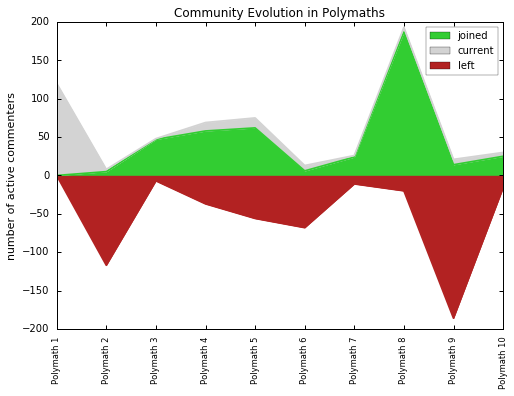

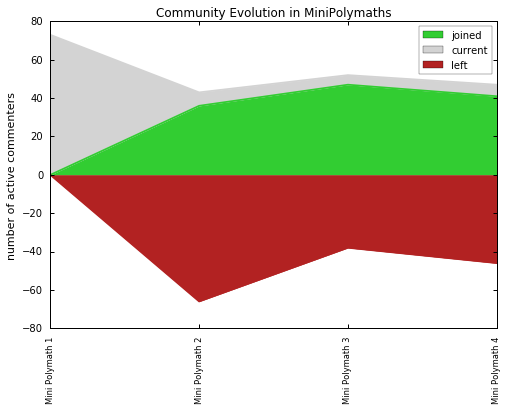

In [45]:
plot_community_evolution("Polymaths")
plot_community_evolution("MiniPolymaths")

In [69]:
def plot_community_project(project, compress=1, sel=[], sharex=True):
    data = mPM_FRAME.loc[project] if project.startswith("Mini") else PM_FRAME.loc[project]
    plot_community(project, data, 'authors', compress=compress, sel=sel, sharex=sharex)

def plot_community(project, data, what, compress=1, sel=[], sharex=True):
    # data for evolution
    added = (data[what] - data[what].shift(1)).apply(lambda x: 0 if isinstance(x, float) else len(x))
    removed = (data[what].shift(1) - data[what]).apply(lambda x: 0 if isinstance(x, float) else - len(x))
    size = data[what].apply(len) - added
    df1 = DataFrame({'joined' : added, 'left' : removed, 'current': size},
                   columns=["joined", "current", "left"], index=data.index)
    df1.index.name = "Threads"
    # data for engagement
    authors = data[what].apply(len)
    engagement = authors / data['number of comments']
    df2 = DataFrame({'research threads': engagement[data['research']],
                    'discussion threads': engagement[~data['research']]},
                   #columns = ['research threads', 'discussion threads'],
                   index=data.index)
    sizes = (data['number of comments'] / compress).tolist()
    df2.index.name = "Threads"
    # setting up plot
    matplotlib.style.use('seaborn-talk')
    fig, axes = plt.subplots(2, 1, figsize=(15, 6), squeeze=False, sharex=sharex)
    plt.subplots_adjust(hspace=0.2)
    # plot bottom
    df1.plot(kind="area", ax = axes[1][0], title="",
            color=['limegreen', 'lightgrey', 'firebrick'], stacked=True)
    axes[1][0].set_xticks(df1.index)
    axes[1][0].set_xticklabels(data['title'], rotation=90, fontsize='small')
    axes[1][0].set_xlabel("")
    axes[1][0].set_ylabel('active commenters')
    # plot top
    df2.plot(kind='bar', ax = axes[0][0], color=['lightsteelblue', 'steelblue'],
                   title = "Community engagement in {}".format(project))
    axes[0][0].set_ylabel('comments per participant')
    axes[0][0].set_yticklabels([round(1/i, 2) for i in axes[0][0].get_yticks()])
    axes[0][0].set_xticklabels(df2.index, fontsize='small')
    axes[0][0].set_xlabel("")
    for container in axes[0][0].containers:
        for i, child in enumerate(container.get_children()):
            child.set_x(df2.index[i] - sizes[i]/2)
            plt.setp(child, width=sizes[i])
    for i in engagement.index:
            if i in sel:
                axes[0][0].text(engagement.index[i] + .2, engagement[i],
                          "{} comments\n {} commenters".format(data['number of comments'][i], authors[i]),
                          ha="center", va="bottom", fontsize='small')

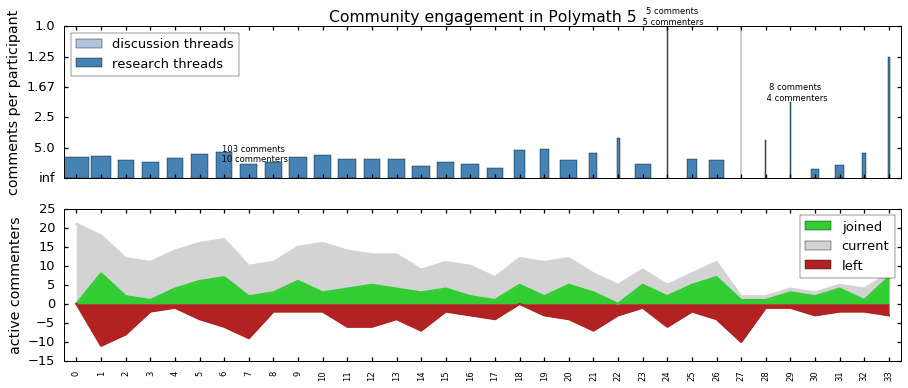

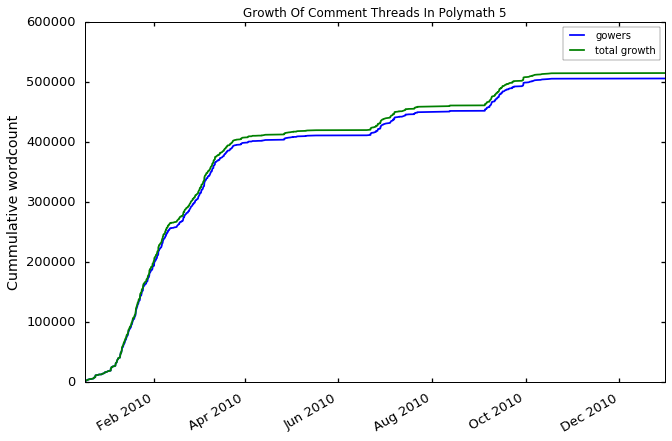

In [70]:
plot_community_project("Polymath 5", compress=150, sel=[7, 24, 29], sharex=True)
plot_growth("Polymath 5", last="2010-12-31")

A problem with the above plots is that there is no way to connect threads to dates.

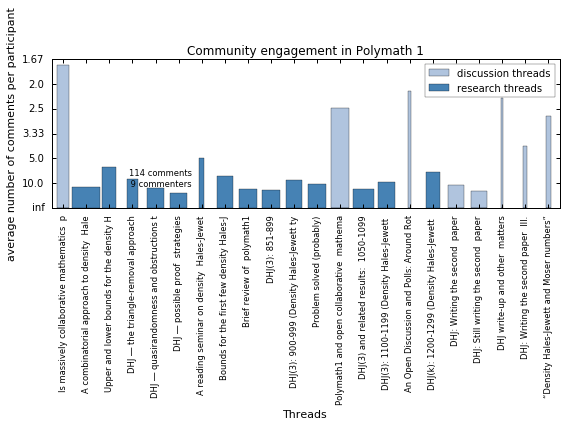

In [48]:
plot_community_engagement("Polymath 1", compress=150, sel=[4, 29])

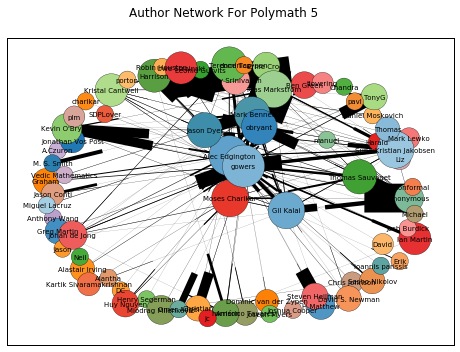

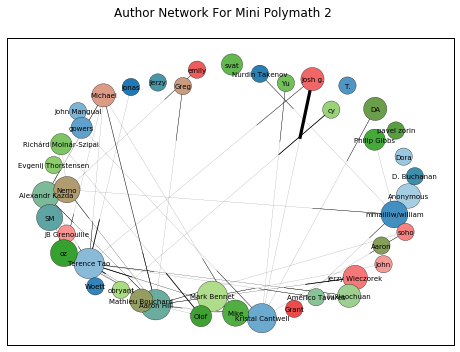

In [49]:
draw_network("Polymath 5")
draw_network("Mini Polymath 2")

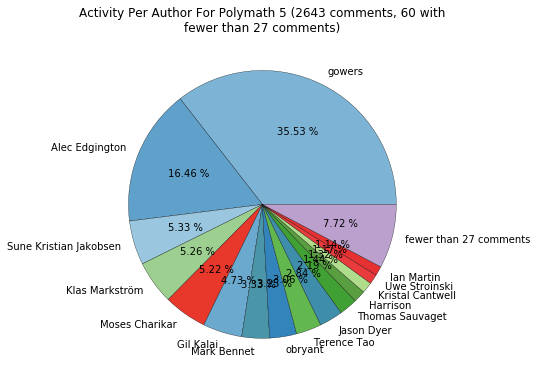

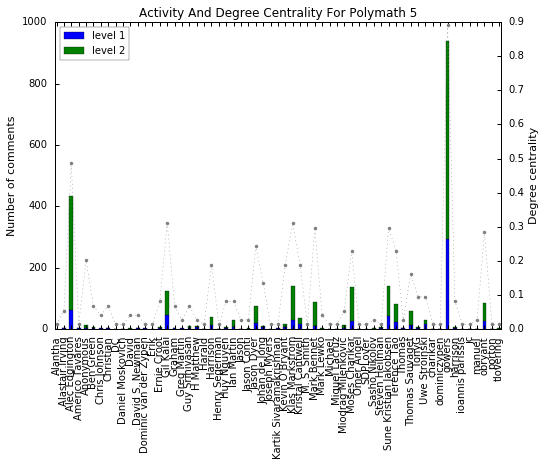

In [50]:
plot_activity_pie("Polymath 5")
plot_activity_degree("Polymath 5")

## Comparing the sizes of the projects

In [51]:
PM_FRAME['number of comments'].describe()

count    127.000000
mean      82.133858
std       53.060367
min        2.000000
25%       40.000000
50%       92.000000
75%      110.500000
max      416.000000
Name: number of comments, dtype: float64

       research only  discussion only       both
count      10.000000        10.000000  10.000000
mean       45.900000         9.400000   5.000000
std        55.414499        23.243637   7.788881
min         5.000000         0.000000   0.000000
25%        21.250000         0.000000   0.000000
50%        27.000000         0.000000   0.500000
75%        43.250000         6.000000   6.250000
max       193.000000        75.000000  21.000000


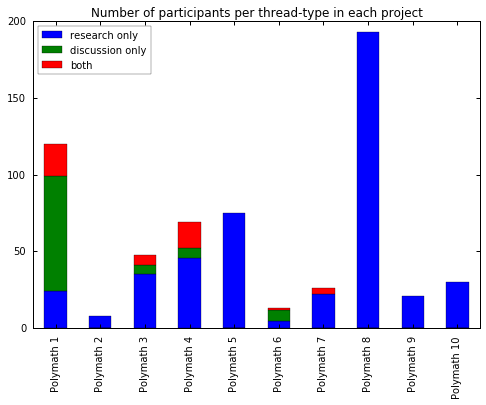

In [52]:
PROJECTS_TO_C = ["Polymath {}".format(i) for i in range(1, 11)]
PARTICIPANTS = Series([PM_FRAME.loc[project]['authors (accumulated)'].iloc[-1] for
                project in PROJECTS_TO_C], index=PROJECTS_TO_C)
R_NETWORKS = Series([PM_FRAME.loc[project]['r_network'].dropna().iloc[-1] for project in PROJECTS_TO_C],
                    index=PROJECTS_TO_C)
WITH_D = [project for project in PROJECTS_TO_C if not PM_FRAME.loc[project]['research'].all()]
D_NETWORKS = Series([PM_FRAME.loc[project]['d_network'].dropna().iloc[-1] for project in WITH_D],
                    index=WITH_D)
R_PARTICIPANTS = R_NETWORKS.apply(lambda network: set(network.author_frame.index))
D_PARTICIPANTS = D_NETWORKS.apply(lambda network: set(network.author_frame.index))

df = DataFrame({'all threads': PARTICIPANTS, 'research threads': R_PARTICIPANTS, 'discussion threads': D_PARTICIPANTS},
              index=PROJECTS_TO_C)
df['research only'] = df['research threads'] - df['discussion threads']
df['discussion only'] = df['discussion threads'] - df['research threads']
df['both'] = df['all threads'] - df['research only'] - df['discussion only']
for project in PROJECTS_TO_C:
    if pd.isnull(df.loc[project]['research only']):
        df.loc[project]['research only'] = df.loc[project]['all threads']
data = df[['research only', 'discussion only', 'both']]
data = data.applymap(lambda set: len(set) if pd.notnull(set) else 0)
print(data.describe())
data.plot(kind='bar', stacked=True, title="Number of participants per thread-type in each project")

       research only  discussion only      both
count       4.000000         4.000000  4.000000
mean       34.750000        13.000000  6.000000
std         9.322911         8.445906  3.464102
min        21.000000         5.000000  1.000000
25%        33.000000         7.250000  5.500000
50%        38.500000        11.500000  7.000000
75%        40.250000        17.250000  7.500000
max        41.000000        24.000000  9.000000


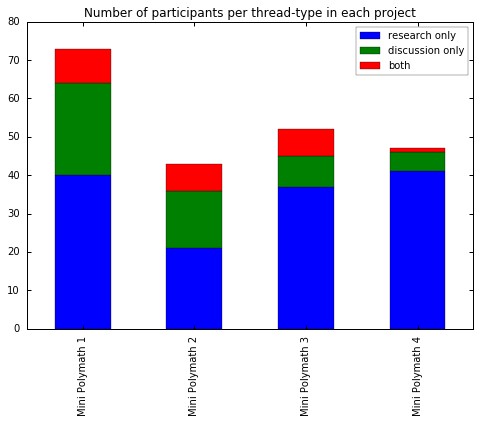

In [53]:
PROJECTS_TO_C = ["Mini Polymath {}".format(i) for i in range(1, 5)]
PARTICIPANTS = Series([mPM_FRAME.loc[project]['authors (accumulated)'].iloc[-1] for
                project in PROJECTS_TO_C], index=PROJECTS_TO_C)
R_NETWORKS = Series([mPM_FRAME.loc[project]['r_network'].dropna().iloc[-1] for project in PROJECTS_TO_C],
                    index=PROJECTS_TO_C)
WITH_D = [project for project in PROJECTS_TO_C if not mPM_FRAME.loc[project]['research'].all()]
D_NETWORKS = Series([mPM_FRAME.loc[project]['d_network'].dropna().iloc[-1] for project in WITH_D],
                    index=WITH_D)
R_PARTICIPANTS = R_NETWORKS.apply(lambda network: set(network.author_frame.index))
D_PARTICIPANTS = D_NETWORKS.apply(lambda network: set(network.author_frame.index))

df = DataFrame({'all threads': PARTICIPANTS, 'research threads': R_PARTICIPANTS, 'discussion threads': D_PARTICIPANTS},
              index=PROJECTS_TO_C)
df['research only'] = df['research threads'] - df['discussion threads']
df['discussion only'] = df['discussion threads'] - df['research threads']
df['both'] = df['all threads'] - df['research only'] - df['discussion only']
for project in PROJECTS_TO_C:
    if pd.isnull(df.loc[project]['research only']):
        df.loc[project]['research only'] = df.loc[project]['all threads']
data = df[['research only', 'discussion only', 'both']]
data = data.applymap(lambda set: len(set) if pd.notnull(set) else 0)
print(data.describe())
data.plot(kind='bar', stacked=True, title="Number of participants per thread-type in each project")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c6ca70b8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1c8ca14a8>]], dtype=object)

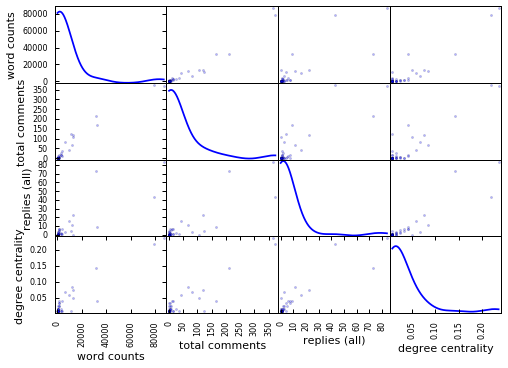

In [54]:
PM1_AFRAME = PM_FRAME.loc['Polymath 1'].iloc[-1]['network'].author_frame
AFRAME = PM1_AFRAME[['word counts', 'total comments', 'replies (all)', 'degree centrality']]
pd.scatter_matrix(AFRAME[AFRAME['degree centrality'] != 0], diagonal='kde', color='k', alpha=0.3)

## Comparing projects and mini-projects

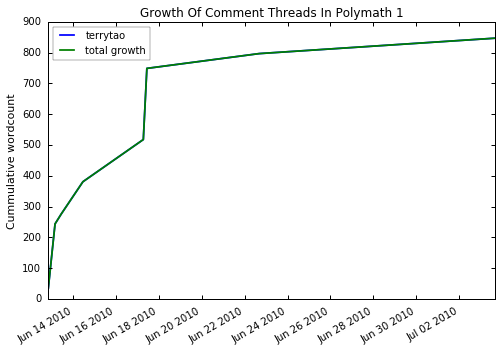

In [55]:
mPM_FRAME['mthread (accumulated)'].iloc[3].plot_growth()